In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [12]:
# TASK 1: Maps and Colormaps (5 Points)

# Load the geographical data (shapefile)
shapefile_path = "ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

# Load the Gini Index data from CSV
gini_df = pd.read_csv("EconomicData.csv")

# Clean and prepare the data
# Rename columns for consistency
gini_df.columns = ['Country', 'GDP_Per_Capita', 'Gini_Index', 'GDP']
# Remove duplicate entries (e.g., "DR Congo")
gini_df = gini_df.drop_duplicates(subset=['Country'])
# Convert Gini Index to numeric, handling missing values
gini_df['Gini_Index'] = pd.to_numeric(gini_df['Gini_Index'], errors='coerce')

# Merge the Gini data with the shapefile
world = world.merge(gini_df[['Country', 'Gini_Index']], 
                    how='left', 
                    left_on='SOVEREIGNT', 
                    right_on='Country')

# Calculate the mean Gini and deviation for the diverging map
mean_gini = world['Gini_Index'].mean()
world['Gini_Deviation'] = world['Gini_Index'] - mean_gini

print("Data loaded and prepared successfully!")
print(f"Mean Gini Index: {mean_gini:.3f}")
print(world[['SOVEREIGNT', 'Gini_Index', 'Gini_Deviation']].head())

Data loaded and prepared successfully!
Mean Gini Index: 0.380
                    SOVEREIGNT  Gini_Index  Gini_Deviation
0                         Fiji       0.367       -0.012788
1  United Republic of Tanzania         NaN             NaN
2               Western Sahara         NaN             NaN
3                       Canada       0.333       -0.046788
4     United States of America         NaN             NaN


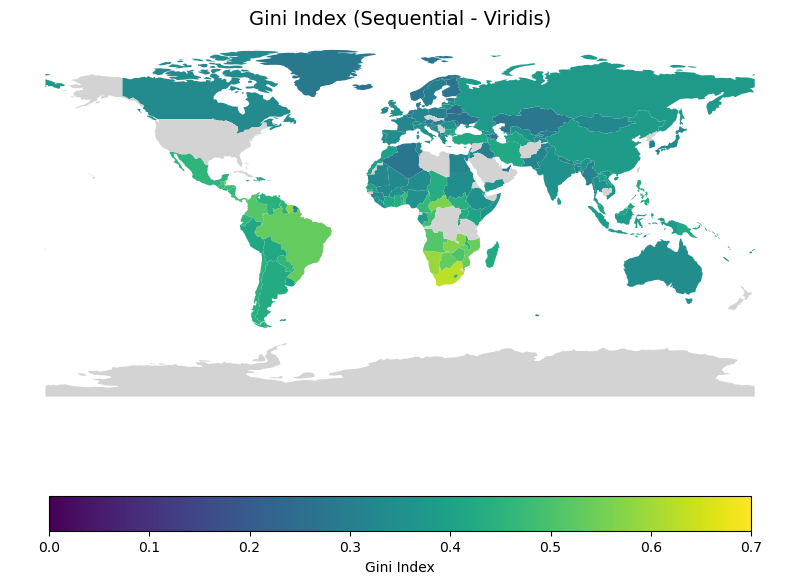

In [13]:
# Create a figure for the sequential map
fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'aspect': 'equal'})

# Plot the sequential choropleth map
world.plot(
    column='Gini_Index', 
    ax=ax, 
    cmap='viridis', 
    legend=True, 
    legend_kwds={'label': "Gini Index", 'orientation': "horizontal", 'shrink': 0.6},
    missing_kwds={'color': 'lightgrey', 'label': 'Missing Data'},
    vmin=0, vmax=0.7  # Set range based on typical Gini values
)

# Customize the plot
ax.set_title("Gini Index (Sequential - Viridis)", fontsize=14)
ax.axis('off')

# Save and display the plot
plt.tight_layout()
plt.savefig("gini_sequential_map.png", dpi=300, bbox_inches='tight')
plt.show()

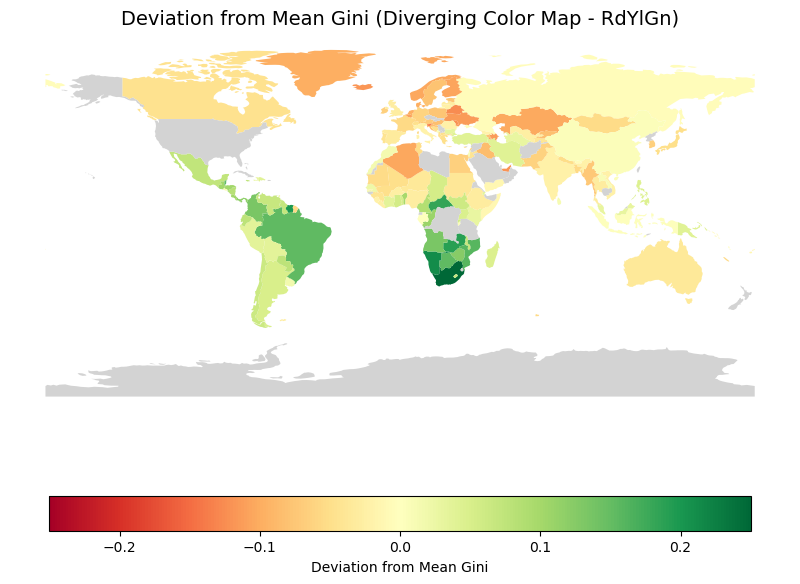

In [24]:
# Create a figure for the diverging map
fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'aspect': 'equal'})

# Ensure symmetric scaling around zero for deviations
max_deviation = np.max(np.abs(world['Gini_Deviation'].dropna()))
vmin, vmax = -max_deviation, max_deviation

# Plot the diverging choropleth map
world.plot(
    column='Gini_Deviation', 
    ax=ax, 
    cmap='RdYlGn', 
    legend=True, 
    legend_kwds={'label': "Deviation from Mean Gini", 'orientation': "horizontal", 'shrink': 0.6},
    vmin=vmin, vmax=vmax,  # Symmetric range around zero
    missing_kwds={'color': 'lightgrey', 'label': 'Missing Data'}
)

# Customize the plot
ax.set_title("Deviation from Mean Gini (Diverging Color Map - RdYlGn)", fontsize=14)
ax.axis('off')

# Save and display the plot
plt.tight_layout()
plt.savefig("gini_diverging_map.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Import required libraries
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = "EconomicData.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Drop rows with missing Gini Index values and create a clean copy
df_clean = df.dropna(subset=["Gini Index"]).copy()

# Compute median Gini Index for re-expression (to be used in diverging map)
median_gini = df_clean["Gini Index"].median()
df_clean["Gini Diverging"] = df_clean["Gini Index"] - median_gini

# Display basic info to confirm data loading
print("Data loaded successfully!")
print(f"Number of rows after dropping NaN Gini values: {len(df_clean)}")
print(f"Median Gini Index: {median_gini:.3f}")
print(df_clean[["Region", "Gini Index", "Gini Diverging"]].head())

Data loaded successfully!
Number of rows after dropping NaN Gini values: 163
Median Gini Index: 0.368
      Region  Gini Index  Gini Diverging
1    Albania       0.332          -0.036
2    Algeria       0.276          -0.092
4     Angola       0.513           0.145
7  Argentina       0.429           0.061
8    Armenia       0.299          -0.069


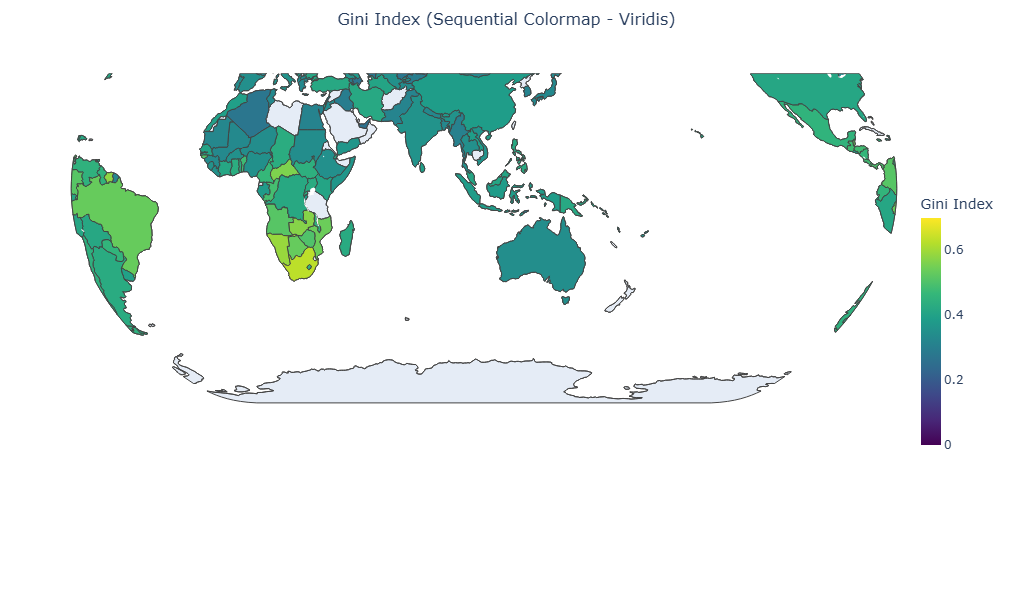

In [45]:
# Create the sequential choropleth map using Viridis colormap
fig1 = px.choropleth(
    df_clean, 
    locations="Region", 
    locationmode="country names",
    color="Gini Index", 
    color_continuous_scale="Viridis",
    title="Gini Index (Sequential Colormap - Viridis)",
    labels={"Gini Index": "Gini Index"},
    range_color=[0, 0.7]  # Set a fixed range for consistency
)

# Update layout to increase map size, adjust legend position, and center the title
fig1.update_layout(
    # Figure size (as in the image: 640x480)
    width=1000,
    height=600,
    # Center the title
    title_x=0.5,  # Center the title horizontally (0.5 = middle)
    title_font_size=16,
    geo=dict(
        showframe=False, 
        showcountries=True,
        projection_type="natural earth",
        fitbounds="locations"
    ),
    coloraxis_colorbar=dict(
        title="Gini Index",
        x=0.95,
        y=0.5,
        xanchor="left",
        yanchor="middle",
        len=0.5,
        thickness=20
    ),
    margin=dict(l=10, r=10, t=50, b=10)
)

# Display the map
fig1.show()

# Save the figure as HTML
fig1.write_html("gini_sequential_map.html")

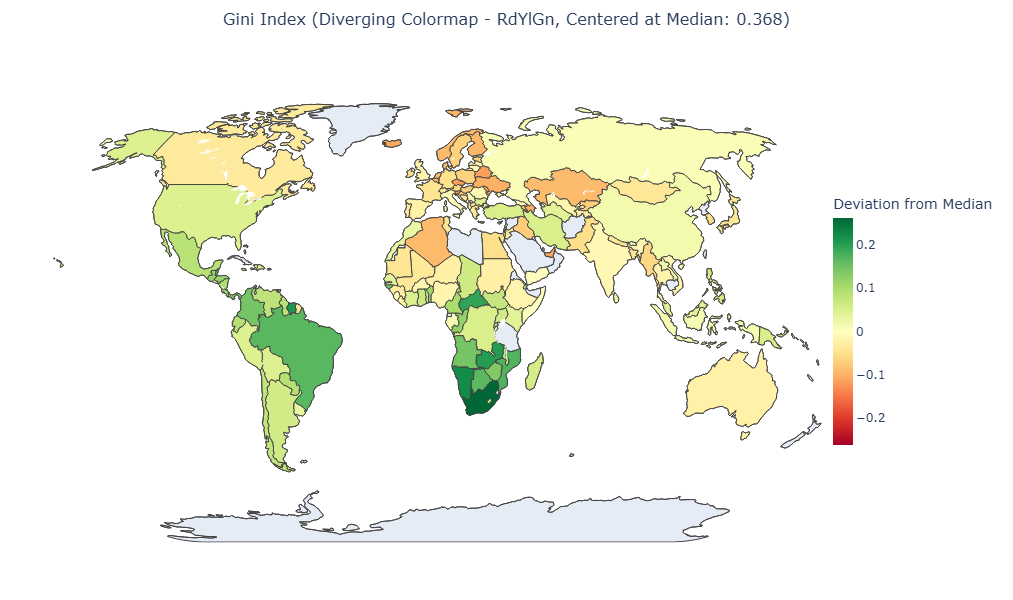

In [49]:
# Calculate the maximum absolute deviation for symmetric scaling
max_deviation = df_clean["Gini Diverging"].abs().max()

# Create the diverging choropleth map using RdBu colormap
fig2 = px.choropleth(
    df_clean, 
    locations="Region", 
    locationmode="country names",
    color="Gini Diverging", 
    color_continuous_scale="RdYlGn",
    title=f"Gini Index (Diverging Colormap - RdYlGn, Centered at Median: {median_gini:.3f})",
    labels={"Gini Diverging": "Deviation from Median Gini"},
    range_color=[-max_deviation, max_deviation]
)

# Update layout to increase map size, adjust legend position, and center the title
fig2.update_layout(
    width=1000,
    height=600,
    title_x=0.5,  # Center the title
    title_font_size=16,
    geo=dict(
        showframe=False, 
        showcountries=True,
        projection_type="natural earth",
        fitbounds="locations"
    ),
    coloraxis_colorbar=dict(
        title="Deviation from Median",
        x=0.95,
        y=0.5,
        xanchor="left",
        yanchor="middle",
        len=0.5,
        thickness=20
    ),
    margin=dict(l=10, r=10, t=50, b=10)
)

# Display the map
fig2.show()

# Save the figure as HTML
fig2.write_html("gini_diverging_map.html")

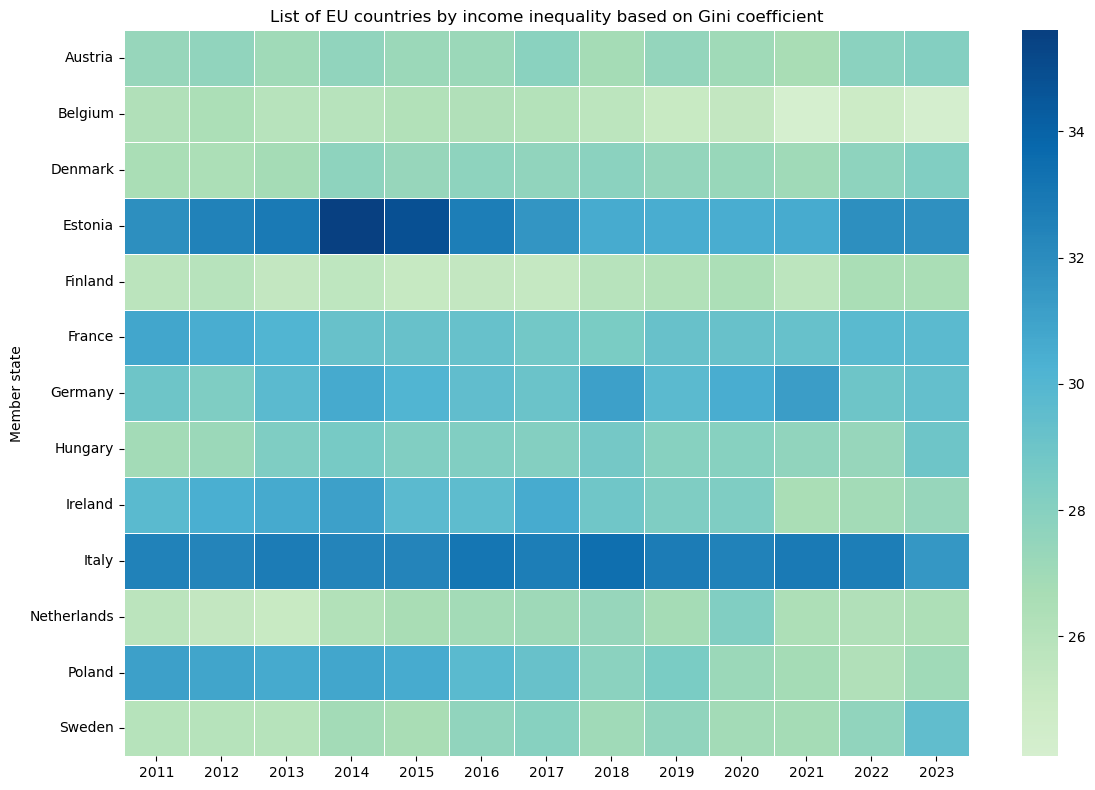

In [2]:
# TASK 2: Heatmaps and Clustermaps (5 Points)
data = {
    'Member state': ['Austria', 'Belgium', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 
                    'Hungary', 'Ireland', 'Italy', 'Netherlands', 'Poland', 'Sweden'],
    '2011': [27.4, 26.3, 26.6, 31.9, 25.8, 30.8, 29.0, 26.9, 29.8, 32.5, 25.8, 31.1, 26.0],
    '2012': [27.6, 26.5, 26.5, 32.5, 25.9, 30.5, 28.3, 27.2, 30.4, 32.4, 25.4, 30.9, 26.0],
    '2013': [27.0, 25.9, 26.8, 32.9, 25.4, 30.1, 29.7, 28.3, 30.7, 32.8, 25.1, 30.7, 26.0],
    '2014': [27.6, 25.9, 27.7, 35.6, 25.6, 29.2, 30.7, 28.6, 31.1, 32.4, 26.2, 30.8, 26.9],
    '2015': [27.2, 26.2, 27.4, 34.8, 25.2, 29.2, 30.1, 28.2, 29.7, 32.4, 26.7, 30.6, 26.7],
    '2016': [27.2, 26.3, 27.7, 32.7, 25.4, 29.3, 29.5, 28.2, 29.6, 33.1, 26.9, 29.8, 27.6],
    '2017': [27.9, 26.1, 27.6, 31.6, 25.3, 28.8, 29.1, 28.1, 30.6, 32.7, 27.1, 29.2, 28.0],
    '2018': [26.8, 25.7, 27.8, 30.6, 25.9, 28.5, 31.1, 28.7, 28.9, 33.4, 27.4, 27.8, 27.0],
    '2019': [27.5, 25.1, 27.5, 30.5, 26.2, 29.2, 29.7, 28.0, 28.3, 32.8, 26.8, 28.5, 27.6],
    '2020': [27.0, 25.4, 27.3, 30.5, 26.5, 29.2, 30.5, 28.0, 28.3, 32.5, 28.2, 27.2, 26.9],
    '2021': [26.7, 24.1, 27.0, 30.6, 25.7, 29.3, 31.2, 27.6, 26.6, 32.9, 26.4, 26.8, 26.8],
    '2022': [27.8, 24.9, 27.7, 31.9, 26.6, 29.8, 29.0, 27.4, 26.9, 32.7, 26.3, 26.3, 27.6],
    '2023': [28.1, 24.2, 28.2, 31.8, 26.6, 29.7, 29.4, 29.0, 27.4, 31.5, 26.4, 27.0, 29.5]
}

df = pd.DataFrame(data)
df.set_index('Member state', inplace=True)

# 1. Basic Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df, 
            cmap='GnBu',  # Red-Yellow-Blue diverging colormap
            annot=False,        # Show values in cells
            fmt='.1f',        # Format numbers with 1 decimal
            linewidth=.5,
            center=df.values.mean())  # Center the colormap at mean value
plt.title('List of EU countries by income inequality based on Gini coefficient')
plt.tight_layout()
# plt.savefig('basic_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1000x800 with 0 Axes>

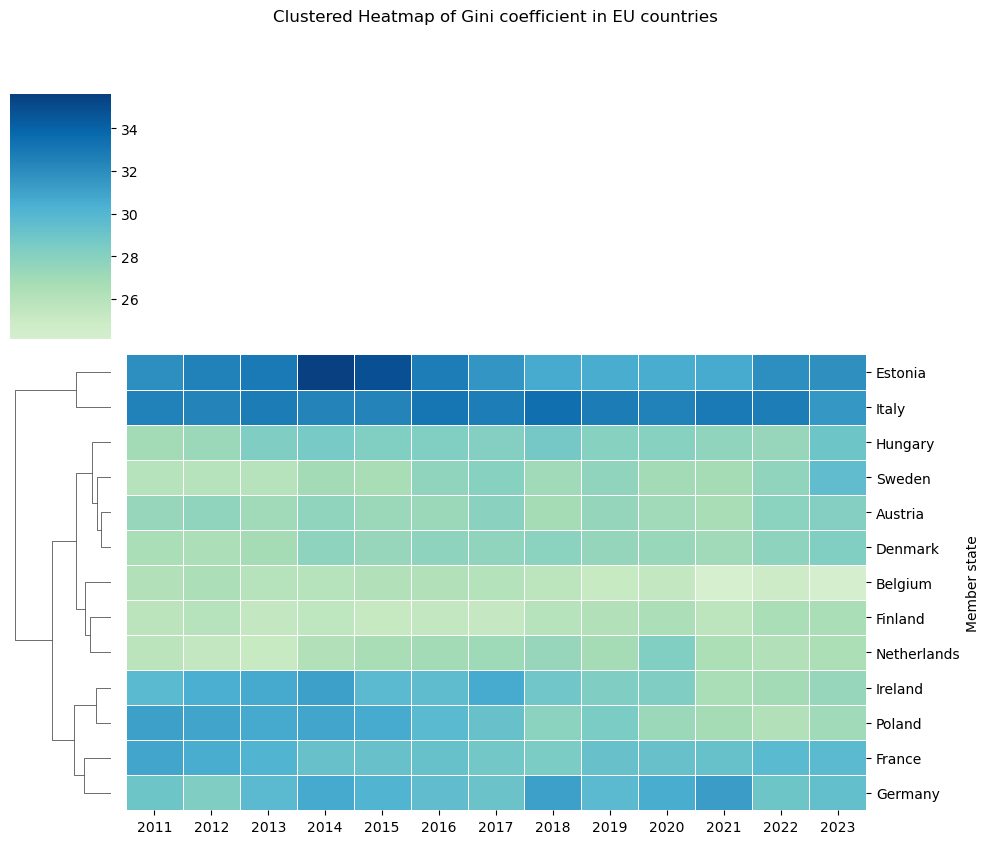

In [5]:
# 2. Clustermap
plt.figure(figsize=(10, 8))
clustermap = sns.clustermap(df,
                            cmap='GnBu',      # Same diverging colormap
                            center=df.values.mean(),  # Center at mean
                            annot=False,           # Show values
                            fmt='.1f',            # Number format
                            dendrogram_ratio=(.12, .35),
                            col_cluster=False,    # Don't cluster columns (maintain time order)
                            row_cluster=True,     # Cluster rows (countries)
                            linewidth=.5,
                            method='average',     # UPGMA clustering method
                            metric='euclidean',   # Distance metric
                            figsize=(10, 8))      # Figure size
clustermap.fig.suptitle('Clustered Heatmap of Gini coefficient in EU countries', 
                       y=1.05,  # Adjust vertical position
                       ha='center')  # Horizontal alignment center
plt.tight_layout()
plt.savefig('clustermap_plot.png', dpi=300, bbox_inches='tight')
plt.show()
